In [1]:
# Import necessary libraries
import os
import sys
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [2]:
# File path
file_dir = '.\\data\\source\\6_dB_pump\\pump\\id_00\\abnormal\\'
file_name = '00000001.wav'
file_path = os.path.join(file_dir, file_name)

In [3]:
# Load the audio file 
signal, fs = librosa.load(file_path, sr=None, mono=False)
signal = signal[0, :]
print(f"File duration: {librosa.get_duration(filename=file_path)} s, fs={fs} Hz")

File duration: 10.0 s, fs=16000 Hz


C:\Users\ecebo\anaconda3\envs\audio_malfunction_detection\lib\site-packages\librosa\util\utils.py:198: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  warnings.warn(


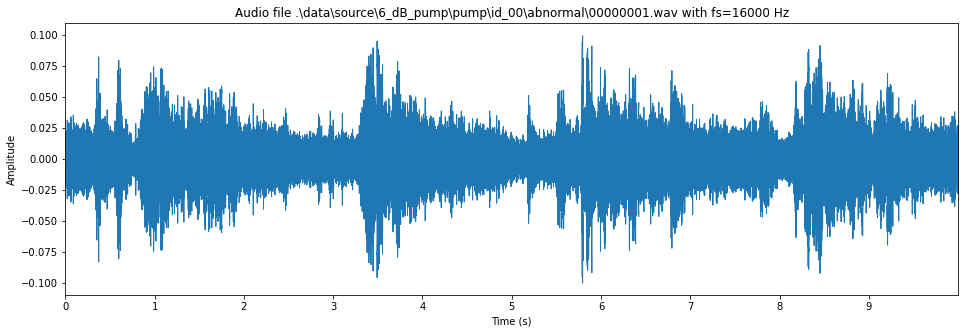

In [4]:
# Plot the signal
plt.figure(figsize=(16,5))
plt.subplot(111)
librosa.display.waveplot(signal, sr=fs)
plt.title(f"Audio file {file_path} with fs={fs} Hz")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

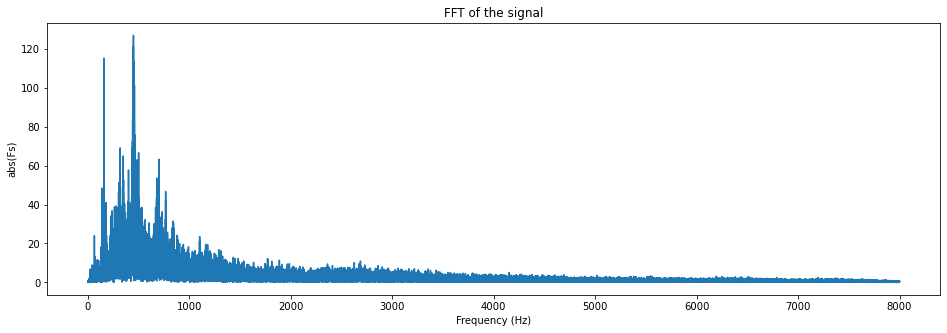

In [5]:
# Compute and plot the FFT
sig_fft = np.fft.fft(signal)
freq = np.linspace(0, fs, len(sig_fft))

sig_fft_left = sig_fft[:len(freq)//2]
freq_left = freq[:len(freq)//2]

plt.figure(figsize=(16,5))
plt.subplot(111)
plt.plot(freq_left, abs(sig_fft_left))
plt.title("FFT of the signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("abs(Fs)")
plt.show()

(10, 513)


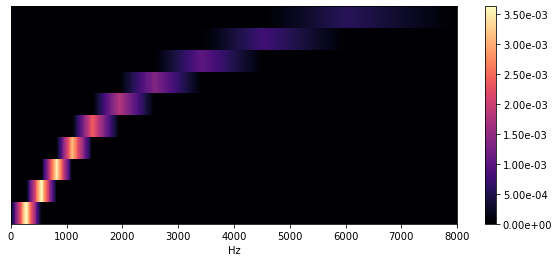

In [6]:
# Mel filter banks
n_fft = 1024
filter_banks = librosa.filters.mel(n_fft=n_fft, sr=fs, n_mels=10)
print(filter_banks.shape)

plt.figure(figsize=(10,4))
librosa.display.specshow(filter_banks, sr=fs, x_axis='linear')
plt.colorbar(format="%.2e")
plt.show()

In [7]:
help(librosa.filters.mel)

Help on function mel in module librosa.filters:

mel(sr, n_fft, n_mels=128, fmin=0.0, fmax=None, htk=False, norm='slaney', dtype=<class 'numpy.float32'>)
    Create a Mel filter-bank.
    
    This produces a linear transformation matrix to project
    FFT bins onto Mel-frequency bins.
    
    Parameters
    ----------
    sr        : number > 0 [scalar]
        sampling rate of the incoming signal
    
    n_fft     : int > 0 [scalar]
        number of FFT components
    
    n_mels    : int > 0 [scalar]
        number of Mel bands to generate
    
    fmin      : float >= 0 [scalar]
        lowest frequency (in Hz)
    
    fmax      : float >= 0 [scalar]
        highest frequency (in Hz).
        If `None`, use ``fmax = sr / 2.0``
    
    htk       : bool [scalar]
        use HTK formula instead of Slaney
    
    norm : {None, 'slaney', or number} [scalar]
        If 'slaney', divide the triangular mel weights by the width of the mel band
        (area normalization).
    
      

{'window': 0.064, 'window_length': 1024, 'overlap': 0.5, 'overlap_length': 512, 'hop_length': 512, 'n_fft': 1024}
Size of mel_spect: (64, 313), total number of points: 20032


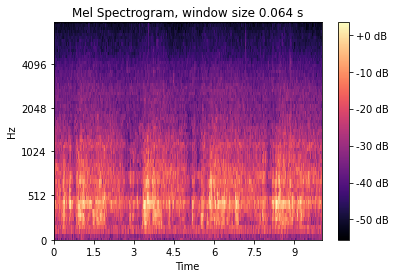

In [8]:
def get_melspectogram(file_path, window, overlap=None, n_fft=None, n_mels=32):
    # Load the signal
    signal, fs = librosa.load(file_path, sr=None)
    
    # Window length in samples
    window_length = int(window*fs)
    
    # Default overlap is 50% of the window size
    if overlap==None:
        overlap = 0.5
    
    # Overlap in samples
    overlap_length = int(window_length*overlap)
    
    # Hop length in samples
    hop_length = window_length-overlap_length
    
    # Default n_fft is the smallest power of 2 larger than win_length
    if n_fft==None:
        n_fft = int(2**np.ceil(np.log2(window_length)))
   
    # Compute mel spectogram
    mel_spect = librosa.feature.melspectrogram(y=signal, sr=fs, 
                                               win_length=window_length, 
                                               hop_length=hop_length,
                                               n_fft=n_fft,
                                               n_mels=n_mels)
    # Mel spectogram in decibels
    mel_spect_db = librosa.power_to_db(mel_spect, ref=1.0, amin=sys.float_info.epsilon, top_db=np.inf)

    params = {}
    params['window'] = window
    params['window_length'] = window_length
    params['overlap'] = overlap
    params['overlap_length'] = overlap_length
    params['hop_length'] = hop_length
    params['n_fft'] = n_fft
    
    return mel_spect, mel_spect_db, params

# Compute and plot mel spectogram
window = 1024/fs # 2
n_mels = 64
mel_spect, mel_spect_db, params = get_melspectogram(file_path, window=window, overlap=0.5, n_mels=n_mels) 

print(params)

print(f"Size of mel_spect: {mel_spect.shape}, total number of points: {mel_spect.size}")
librosa.display.specshow(mel_spect_db, sr=fs, hop_length=params['overlap_length'], x_axis='time', y_axis='mel');
# times = librosa.times_like(mel_spect, sr=fs, hop_length=params['overlap_length'])
# librosa.display.specshow(mel_spect_db, sr=fs, hop_length=params['overlap_length'], x_coords = times, y_axis='mel');

plt.title(f"Mel Spectrogram, window size {params['window']} s");
plt.colorbar(format='%+2.0f dB');

In [9]:
n_frames = 5
dims = n_mels * n_frames
vectorarray_size = len(mel_spect_db[0, :]) - n_frames + 1

print("vectorarray_size:", vectorarray_size)

vectorarray = np.zeros((vectorarray_size, dims), float)
print("vectorarray: ", vectorarray.shape)

for t in range(n_frames):
    print(t, t + vectorarray_size)
    print(n_mels*t, n_mels*(t + 1))
    print("\n")
    vectorarray[:, n_mels*t : n_mels*(t + 1)] = mel_spect_db[:, t: t + vectorarray_size].T


vectorarray.shape

vectorarray_size: 309
vectorarray:  (309, 320)
0 309
0 64


1 310
64 128


2 311
128 192


3 312
192 256


4 313
256 320




(309, 320)

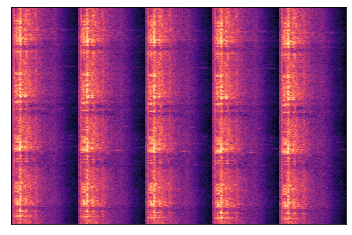

In [10]:
librosa.display.specshow(vectorarray)

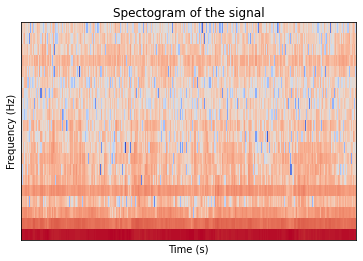

In [11]:
win_length = params['window_length']
n_fft = params['n_fft']
hop_length = params['hop_length']
n_mfcc = 16
mfcc = librosa.feature.mfcc(signal, n_fft=n_fft, win_length=win_length, hop_length=hop_length)

librosa.display.specshow(np.log10(abs(mfcc)), sr=fs, hop_length=hop_length)
plt.title("Spectogram of the signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

In [12]:
mfcc.shape

(20, 313)